### Tarea 3

#### Librerias

In [188]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from scikitplot.metrics import plot_roc_curve as auc_roc
#from nltk.stem.porter import PorterStemmer
#import nltk
#import string
from nltk.tokenize import word_tokenize
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 
sns.set()

In [189]:
base = pd.read_csv('../Tarea1/Reviews.csv',quotechar="\"",dtype={'stars':'str'})
base['comment'] = base['comment'].apply(lambda x: re.sub('\'','',x))
base['comment'] = base['comment'].apply(lambda x: re.sub('[^a-zA-Z ]',' ',x))
base['LongitudComentario'] = base['comment'].apply(lambda x: len(str(x).split()))
base= base[base.LongitudComentario>=1]
base['sentimiento1'] = np.where(base['stars'].isin(['4.0', '5.0']),1, 0    )
base['sentimientoReal'] = np.where(base['stars'].isin(['4.0', '5.0']),'Positive', 'Negative'   )
#1 = positive
#0 = negative


88.56100988563675


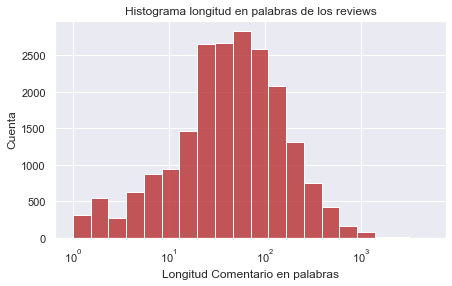

In [190]:
fig = plt.figure(figsize = (7,4))
ax = sns.histplot(data = base, x= 'LongitudComentario',log_scale=True,bins =20,color='firebrick')
ax.set( xlabel = "Longitud Comentario en palabras", ylabel = "Cuenta",title='Histograma longitud en palabras de los reviews')
print(base.LongitudComentario.mean())

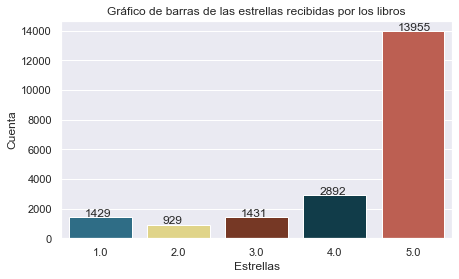

In [191]:
order_list = ['1.0', '2.0', '3.0', '4.0', '5.0']
fig = plt.figure(figsize = (7,4))
ax = sns.countplot(data = base, x = 'stars', order=order_list,palette=['#207394','#eede7b', '#833118','#084152','#cd5241'])
ax.set( xlabel = "Estrellas", ylabel = "Cuenta",title='Gráfico de barras de las estrellas recibidas por los libros')
for p in ax.patches:
        ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+50))


In [192]:
estrellas = []
for r in base.stars:
    estrellas.append(float(r))
sum(estrellas)/len(estrellas)

4.309119984493119

In [193]:
base

,stars,comment,book_url,LongitudComentario,sentimiento1,sentimientoReal
0,5.0,Let me say at the outset of this review that ...,https://www.amazon.com/dp/1492041130,267,1,Positive
1,1.0,Its Capitalism at its best I read the book fr...,https://www.amazon.com/dp/1492041130,194,0,Negative
2,5.0,If youre looking to get started with data scie...,https://www.amazon.com/dp/1492041130,63,1,Positive
3,4.0,In general this is a good book It covers a w...,https://www.amazon.com/dp/1492041130,108,1,Positive
4,5.0,I was an academic data scientist decades befor...,https://www.amazon.com/dp/1492041130,149,1,Positive
...,...,...,...,...,...,...
20642,3.0,This book offers nice information and thoughts...,https://www.amazon.com/dp/0980200482,28,0,Negative
20643,5.0,Am disabled retired RN but always wished I w...,https://www.amazon.com/dp/0980200482,26,1,Positive
20644,3.0,At one point I considered library work as oppo...,https://www.amazon.com/dp/0980200482,89,0,Negative
20645,5.0,Overall I think this is an excellent resource...,https://www.amazon.com/dp/0980200482,89,1,Positive


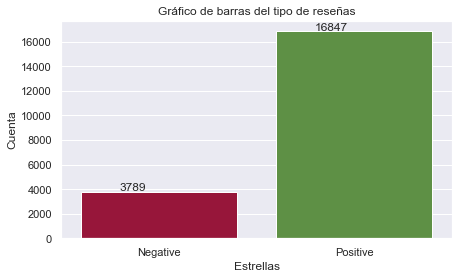

In [194]:
fig = plt.figure(figsize = (7,4))
order_list = [ 'Negative', 'Positive']
ax = sns.countplot(data = base, x = 'sentimientoReal',order=order_list, palette=[ '#ac0031','#5a9c39'])
ax.set( xlabel = "Estrellas", ylabel = "Cuenta",title='Gráfico de barras del tipo de reseñas')
for p in ax.patches:
        ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+50))

In [138]:
base2 = base.drop(['book_url','stars','LongitudComentario','sentimientoReal' ], axis= 1)

In [139]:
base2.shape

(20636, 2)

In [140]:
base2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20636 entries, 0 to 20646
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment       20636 non-null  object
 1   sentimiento1  20636 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 919.1+ KB


In [141]:
display(base2.describe())

,sentimiento1
count,20636.000000
mean,0.816389
std,0.387176
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [143]:
print(base2.isnull().sum())
print('\nNo hay valores nulos')

comment         0
sentimiento1    0
dtype: int64

No hay valores nulos


In [146]:
def preprocesamiento(comentario):
    comentario =  re.sub('[^a-zA-Z]',' ',comentario)
    palabras = word_tokenize(comentario)
    palabras = [palabra.lower() for palabra in palabras ]
    #palabras = [palabra.translate(tabla) for palabra in palabras]
    palabras = [palabra for palabra in palabras if palabra.isalpha()]
    palabras = [palabra for palabra in palabras if not palabra in stop_words]
    palabras = [lemmatizer.lemmatize(palabra) for palabra in palabras]
    palabras = " ".join(palabras)
    return palabras

In [152]:

base2['comment'] = base2['comment'].apply(lambda x: preprocesamiento(x))

In [166]:
tfidf=TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,use_idf=True,norm='l2',smooth_idf=True)
y = base2.sentimiento1.values
x = tfidf.fit_transform(base2.comment)

In [168]:
base2

,comment,sentimiento1
0,let say outset review respect author sheer gui...,1
1,capitalism best read book nearby bookstore lik...,0
2,youre looking get started data science youre c...,1
3,general good book cover wide variety topic go ...,1
4,academic data scientist decade term coined lov...,1
...,...,...
20642,book offer nice information thought thinking b...,0
20643,disabled retired rn always wished librarian pe...,1
20644,one point considered library work opposed work...,0
20645,overall think excellent resource anyone pursui...,1


In [195]:
X = base2.drop(['sentimiento1'],axis=1)
Y = base2['comment']
Train_X, Test_X, Train_Y, Test_Y = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=0)
print('Dimensiones originales: ',X.shape,Y.shape,'\nDimensiones entrenamiento: ',Train_X.shape,Train_Y.shape,'\nDimensiones test: ', Test_X.shape,'', Test_Y.shape)

Dimensiones originales:  (20636, 1) (20636,) 
Dimensiones entrenamiento:  (16508, 30935) (16508,) 
Dimensiones test:  (4128, 30935)  (4128,)


In [197]:
Evaluation_Results = pd.DataFrame(np.zeros((3,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Regresión logistica ','Random Forest','Naïve-Bayes']
Evaluation_Results

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Regresión logistica,0.0,0.0,0.0,0.0,0.0
Random Forest,0.0,0.0,0.0,0.0,0.0
Naïve-Bayes,0.0,0.0,0.0,0.0,0.0


In [215]:
#Resumen
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(Test_Y, pred),3)*100   
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(Test_Y, pred),3)*100 
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(Test_Y, pred),3)*100 
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(Test_Y, pred),3)*100 
    Evaluation_Results.iloc[i]['AUC-ROC score']=round(roc_auc_score(Test_Y, pred),3)*100 


    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred),3)*100)) 
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(Test_Y, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(Test_Y, pred))
    
    auc_roc(Test_Y, pred_prob, curves=['each_class'])
    plt.show()
    



<<<----------------------------------- Evaluating Regresión logistica  ----------------------------------->>>

Accuracy = 87.6%
F1 Score = 92.9%

 Confusiton Matrix:
 [[ 304  451]
 [  59 3314]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.40      0.54       755
           1       0.88      0.98      0.93      3373

    accuracy                           0.88      4128
   macro avg       0.86      0.69      0.74      4128
weighted avg       0.87      0.88      0.86      4128



c:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


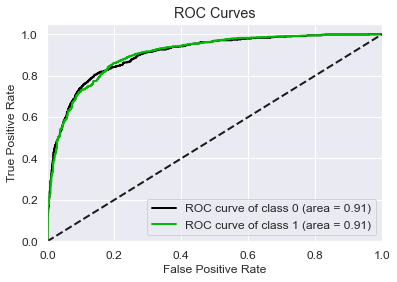

Text(0.5, 1.0, 'Matriz de Confución Regresión Logistica')

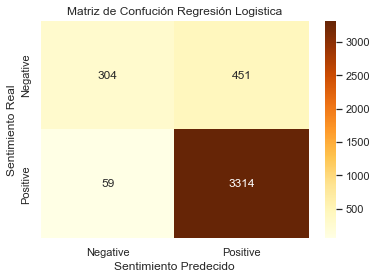

In [223]:
LR_model = LogisticRegression()
LR = LR_model.fit(Train_X, Train_Y)
pred_LR = LR.predict(Test_X)
pred_prob_LR = LR.predict_proba(Test_X)
Classification_Summary(pred_LR,pred_prob_LR,0)

m_LR = confusion_matrix(Test_Y, pred_LR)
sns.heatmap(m_LR,annot=True, cmap="YlOrBr", fmt="d", 
            xticklabels =["Negative",  "Positive"], 
            yticklabels = ["Negative",  "Positive"])
plt.ylabel('Sentimiento Real')
plt.xlabel('Sentimiento Predecido')
plt.title("Matriz de Confución Regresión Logistica")

<<<----------------------------------- Evaluating Random Forest ----------------------------------->>>

Accuracy = 85.6%
F1 Score = 91.8%

 Confusiton Matrix:
 [[ 188  567]
 [  27 3346]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.25      0.39       755
           1       0.86      0.99      0.92      3373

    accuracy                           0.86      4128
   macro avg       0.86      0.62      0.65      4128
weighted avg       0.86      0.86      0.82      4128



c:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


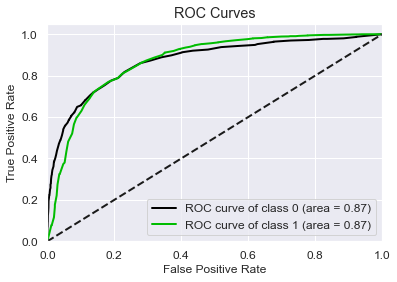

Text(0.5, 1.0, 'Matriz de Confución Random Forest')

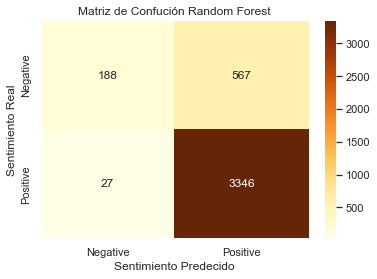

In [224]:
RF_model = RandomForestClassifier()
RF = RF_model.fit(Train_X, Train_Y)
pred_RF = RF.predict(Test_X)
pred_prob_RF = RF.predict_proba(Test_X)

Classification_Summary(pred_RF,pred_prob_RF,1)

m_RF = confusion_matrix(Test_Y, pred_RF)
sns.heatmap(m_RF,annot=True, cmap="YlOrBr", fmt="d", 
            xticklabels =["Negative",  "Positive"], 
            yticklabels = ["Negative",  "Positive"])
plt.ylabel('Sentimiento Real')
plt.xlabel('Sentimiento Predecido')
plt.title("Matriz de Confución Random Forest")

<<<----------------------------------- Evaluating Naïve-Bayes ----------------------------------->>>

Accuracy = 80.30000000000001%
F1 Score = 88.3%

 Confusiton Matrix:
 [[ 223  532]
 [ 283 3090]]

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.30      0.35       755
           1       0.85      0.92      0.88      3373

    accuracy                           0.80      4128
   macro avg       0.65      0.61      0.62      4128
weighted avg       0.78      0.80      0.79      4128



c:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


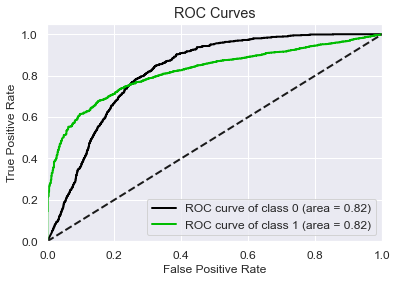

Text(0.5, 1.0, 'Matriz de Confución Naive Bayes')

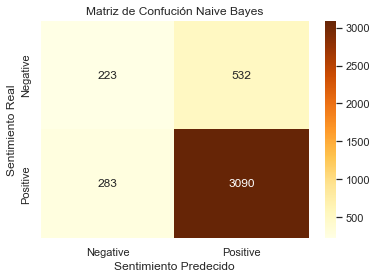

In [225]:
# Building Naive Bayes Classifier

NB_model = BernoulliNB()
NB = NB_model.fit(Train_X, Train_Y)
pred_NB = NB.predict(Test_X)
pred_prob_NB = NB.predict_proba(Test_X)
Classification_Summary(pred_NB,pred_prob_NB,2)

m_NB = confusion_matrix(Test_Y, pred_NB)
sns.heatmap(m_NB,annot=True, cmap="YlOrBr", fmt="d", 
            xticklabels =["Negative",  "Positive"], 
            yticklabels = ["Negative",  "Positive"])
plt.ylabel('Sentimiento Real')
plt.xlabel('Sentimiento Predecido')
plt.title("Matriz de Confución Naive Bayes")

In [226]:
Evaluation_Results

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Regresión logistica,87.6,88.0,98.3,92.9,69.3
Random Forest,85.6,85.5,99.2,91.8,62.1
Naïve-Bayes,80.3,85.3,91.6,88.3,60.6
